In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from OutilsP5 import *

#SciKit-Learn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.pipeline import make_pipeline

from sklearn.compose import make_column_transformer

## Clients

Il y a 0 valeurs manquantes sur 497205 valeurs totales.
Le taux de remplissage est de : 100.0 %
Dimension du dataframe : (99441, 5)


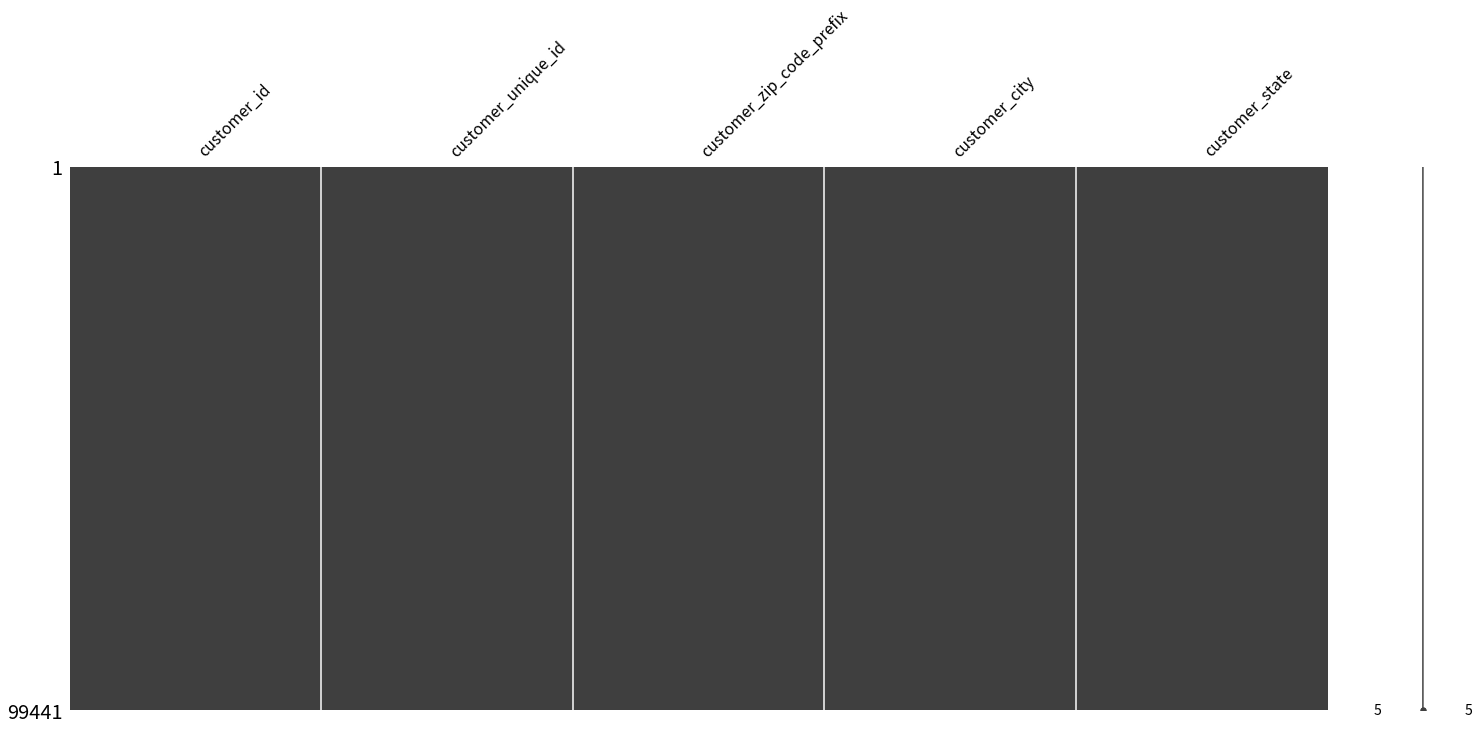

In [2]:
customers_data = pd.read_csv("olist_customers_dataset.csv")
missingValuesInfos(customers_data)

Variables :
- customer_id : id d'un client dpécifique a une commande (clé primaire)
- customer_unique_id : id client 
- customer_zip_code_prefix : code postal d'où vient le client
- customer_city : ville d'où vient le client
- customer_state : département d'où vient le client

In [3]:
print(f"Nombre de clients du site : {customers_data.loc[:,'customer_unique_id'].nunique()}.")

Nombre de clients du site : 96096.


Nombre de départements concernés : 27.

Nombre de codes postaux concernés : 14994.

Départements des clients majoritaire (top 10) :
['sao paulo', 'rio de janeiro', 'belo horizonte', 'brasilia', 'curitiba', 'campinas', 'porto alegre', 'salvador', 'guarulhos', 'sao bernardo do campo'] 



Text(0.5, 1.0, 'Nombre de clients par département')

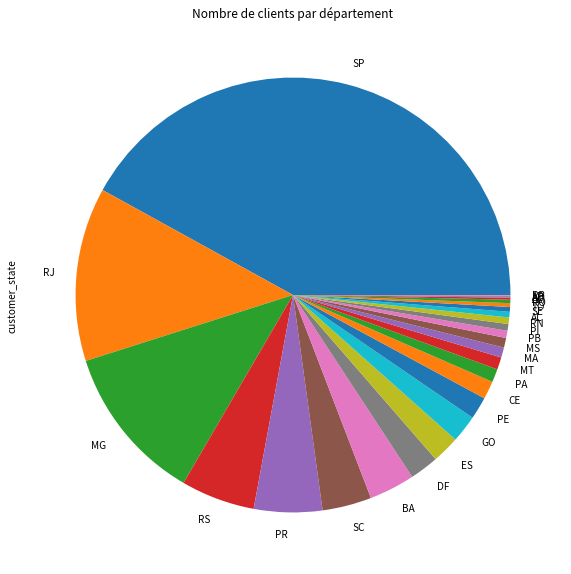

In [4]:
print(f"Nombre de départements concernés : {customers_data['customer_state'].nunique()}.\n")
print(f"Nombre de codes postaux concernés : {customers_data['customer_zip_code_prefix'].nunique()}.\n")
print("Départements des clients majoritaire (top 10) :")
print(customers_data.loc[:,"customer_city"].value_counts().sort_values(ascending = False).head(10).index.tolist(), "\n")
customers_data.loc[:,"customer_state"].value_counts().sort_values(ascending = False).plot.pie(figsize = (10,10))
plt.title("Nombre de clients par département")

## Géolocalisation

Il y a 0 valeurs manquantes sur 5000815 valeurs totales.
Le taux de remplissage est de : 100.0 %
Dimension du dataframe : (1000163, 5)


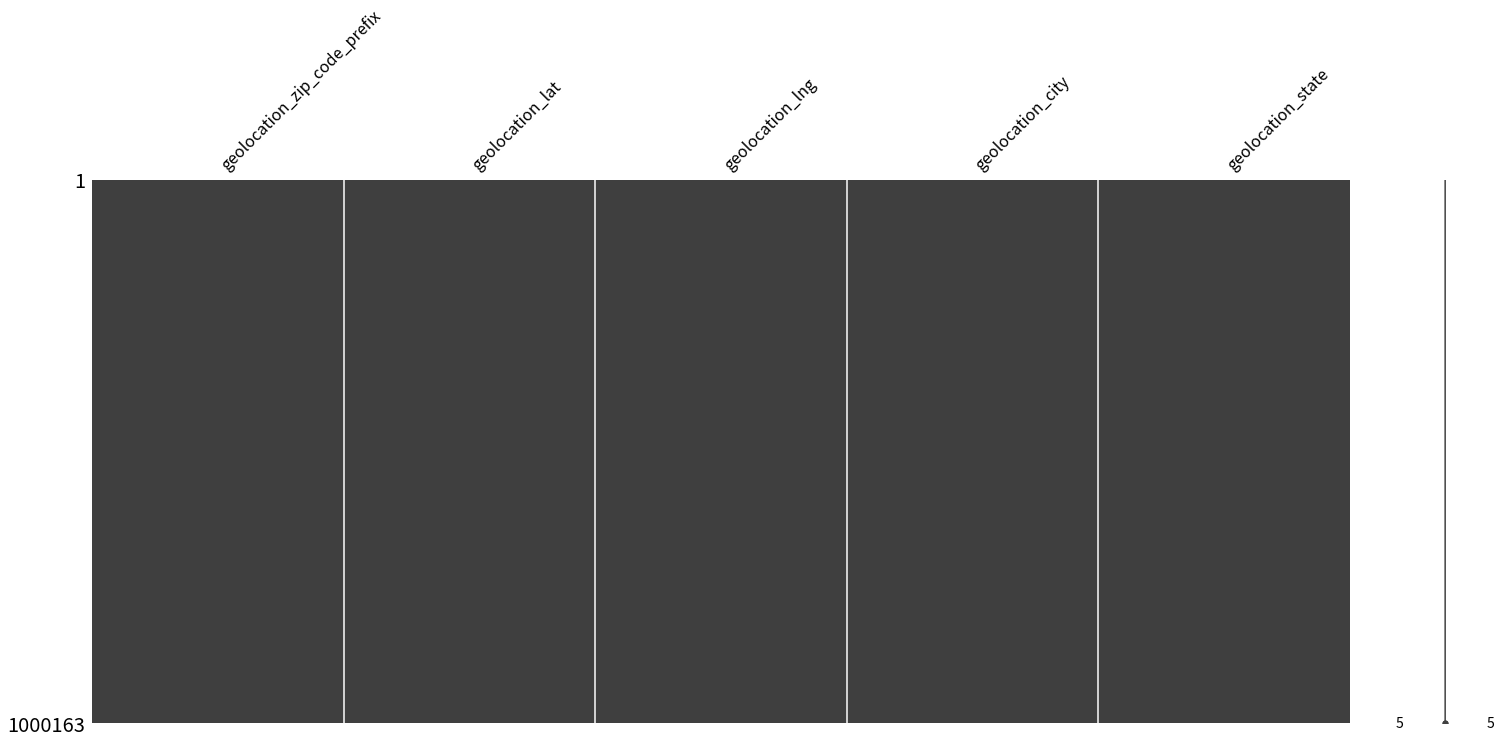

In [5]:
geolocation_data = pd.read_csv("olist_geolocation_dataset.csv")
missingValuesInfos(geolocation_data)

Variables :
- geolocation_zip_code_prefix : Code postal
- geolocation_lat : latitude
- geolocation_lng : longitude
- geolocation_city : ville
- geolocation_state : département

In [6]:
geolocation_data.columns = ['zip_code_prefix','geolocation_lat','geolocation_lng','geolocation_city','geolocation_state']
print(f"Nombre de départements concernés : {geolocation_data['geolocation_state'].nunique()}.\n")
print(f"Nombre de codes postaux concernés : {geolocation_data['zip_code_prefix'].nunique()}.")

Nombre de départements concernés : 27.

Nombre de codes postaux concernés : 19015.


In [7]:
encoder = LabelEncoder()
encoder.fit(geolocation_data["geolocation_state"])
color = encoder.transform(geolocation_data["geolocation_state"])

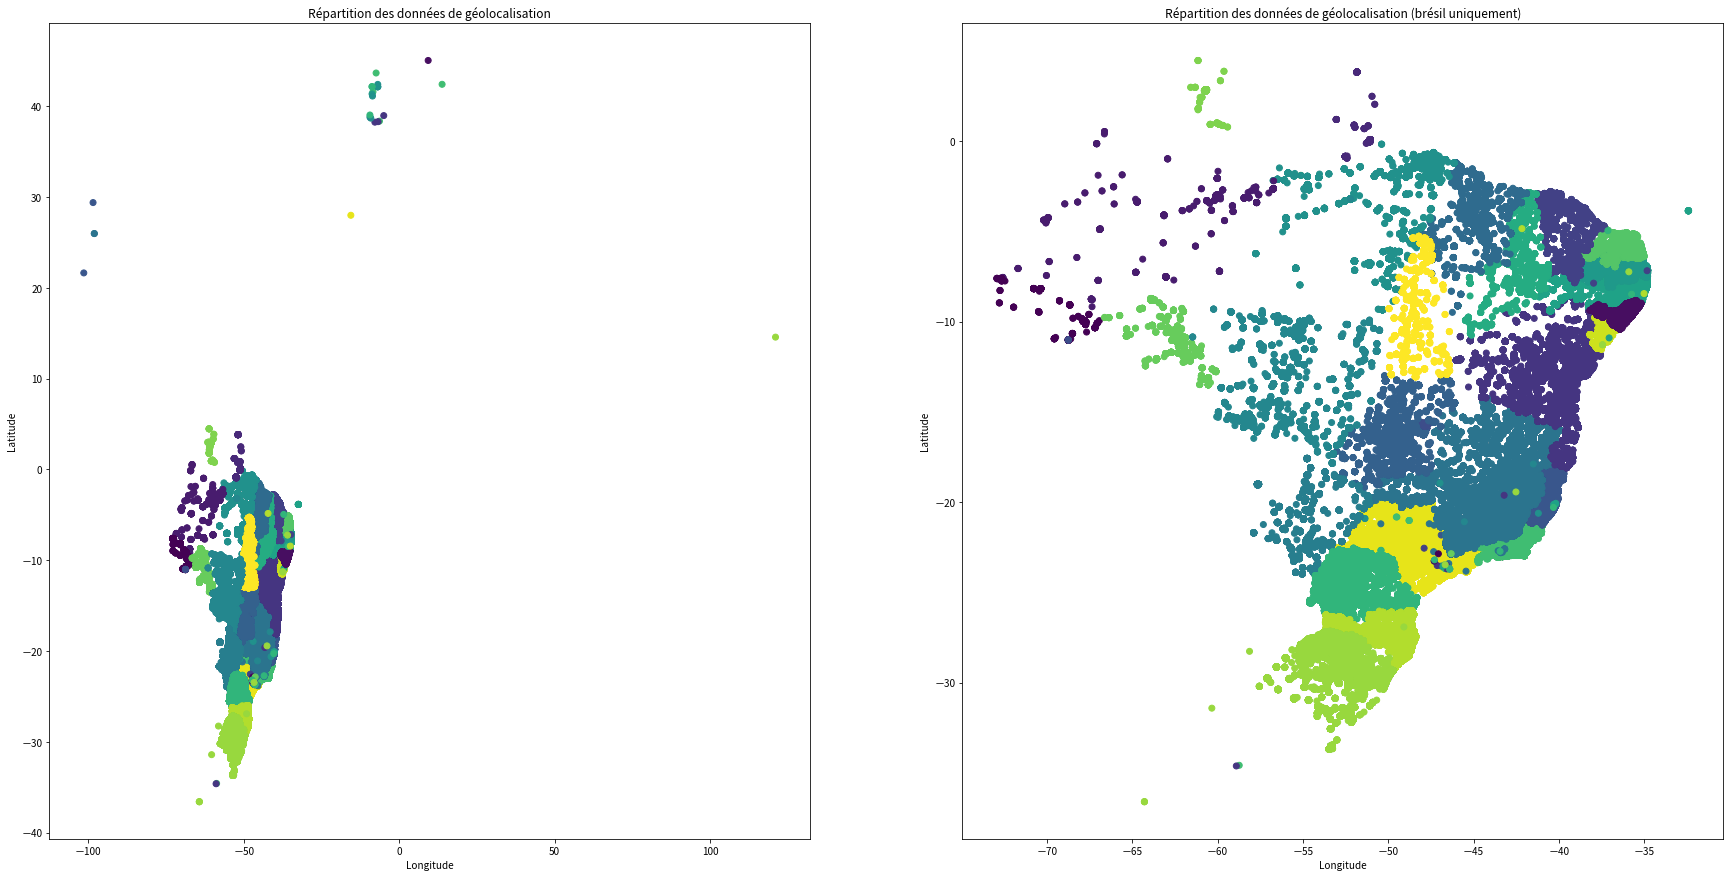

In [8]:
plt.figure(figsize = (30,15))
plt.subplot(1,2,1)
plt.scatter(geolocation_data["geolocation_lng"], geolocation_data["geolocation_lat"], c = color)
plt.title("Répartition des données de géolocalisation")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.subplot(1,2,2)
mask = (geolocation_data["geolocation_lng"] < -18) * (geolocation_data["geolocation_lat"] < 10)
plt.scatter(geolocation_data.loc[mask,"geolocation_lng"], geolocation_data.loc[mask,"geolocation_lat"], c = color[mask])
plt.title("Répartition des données de géolocalisation (brésil uniquement)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [9]:
del mask
del encoder
del color

## Order items

Il y a 0 valeurs manquantes sur 788550 valeurs totales.
Le taux de remplissage est de : 100.0 %
Dimension du dataframe : (112650, 7)


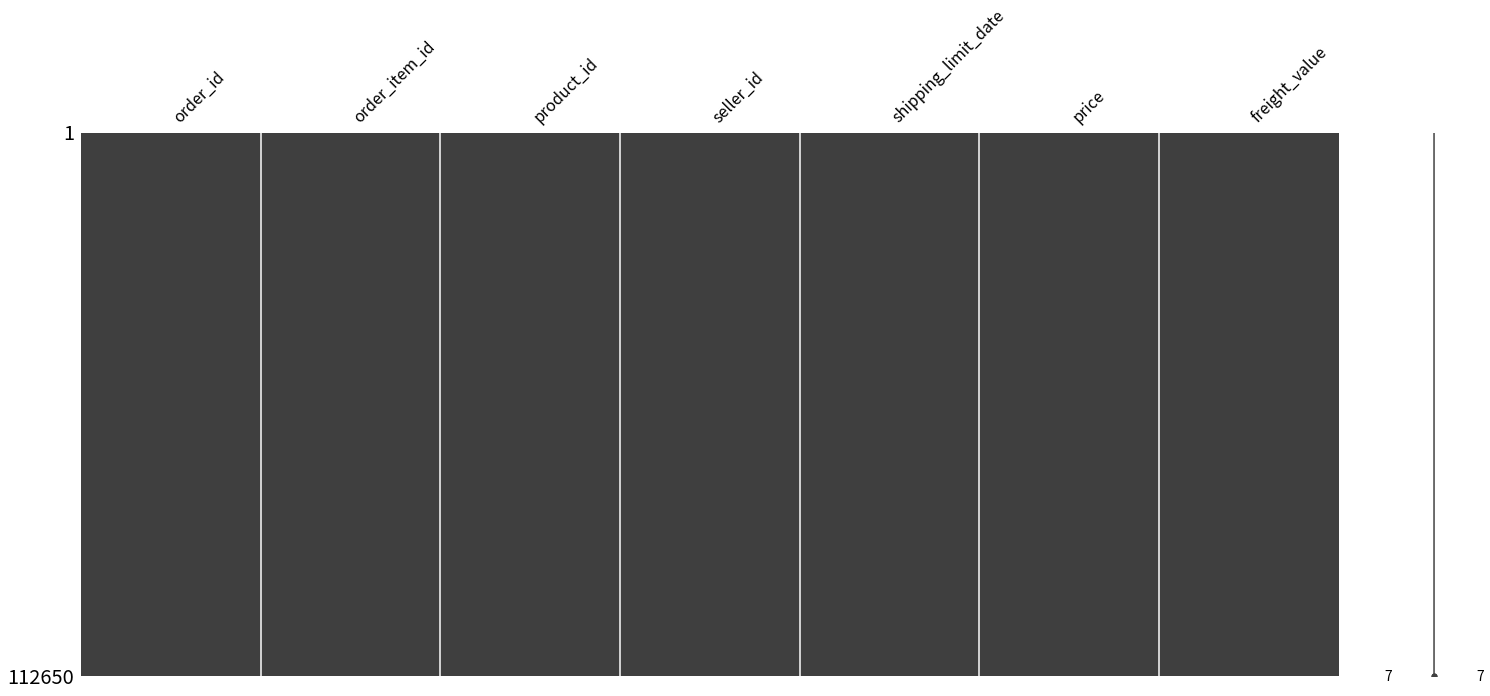

In [10]:
order_items_data = pd.read_csv("olist_order_items_dataset.csv")
missingValuesInfos(order_items_data)

Variable :
- order_id : id de la commande
- order_item_id : numéro du produit dans la commande
- product_id : id du produit
- seller_id : id du vendeur
- shipping_limit_date : date limite d'expédition
- price : prix
- freight_value : valeur de fret (probablement poids de l'article)

In [11]:
order_items_data.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


Text(0.5, 1.0, 'Répartition des prix (log)')

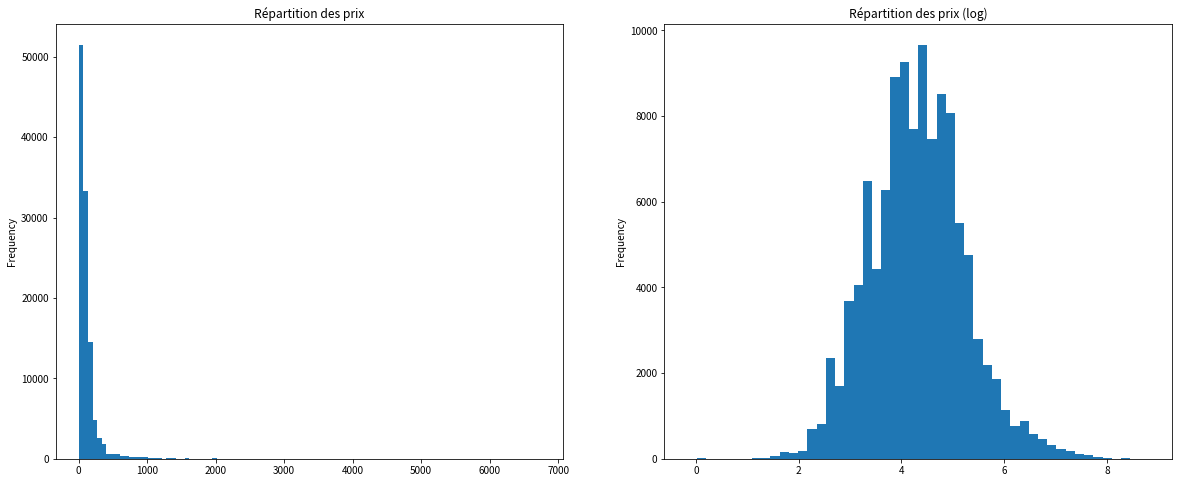

In [12]:
plt.subplot(1,2,1)
order_items_data["price"].plot.hist(bins = 100, figsize = (20,8))
plt.title("Répartition des prix")
plt.subplot(1,2,2)
np.log(order_items_data["price"]).plot.hist(bins = 50, figsize = (20,8))
plt.title("Répartition des prix (log)")

Text(0.5, 1.0, "Nombre d'articles vendus par vendeur (log)")

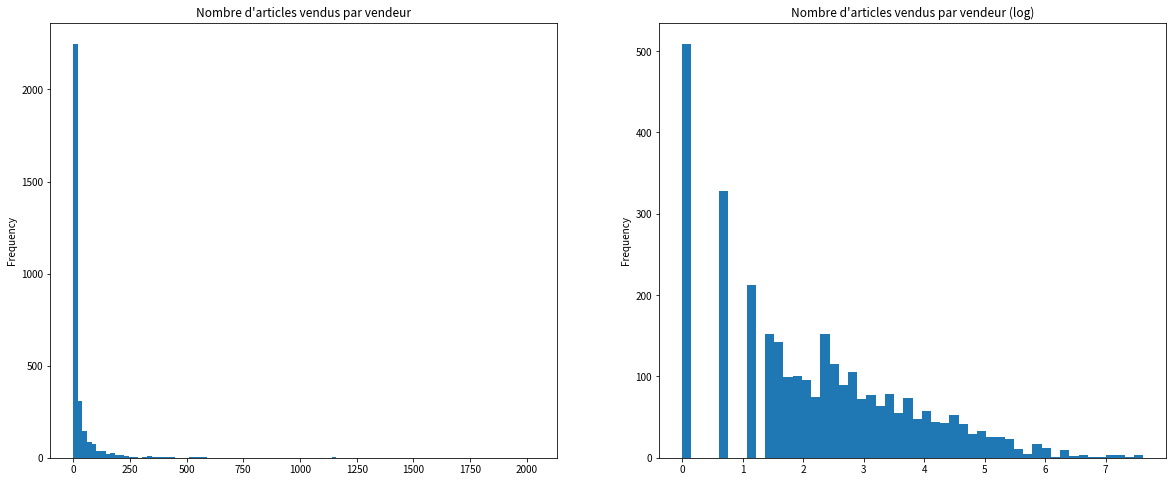

In [13]:
order_items_data['seller_id'].value_counts().plot.hist(figsize = (10,10),bins = 100)
plt.subplot(1,2,1)
order_items_data['seller_id'].value_counts().plot.hist(bins = 100, figsize = (20,8))
plt.title("Nombre d'articles vendus par vendeur")
plt.subplot(1,2,2)
np.log(order_items_data['seller_id'].value_counts()).plot.hist(bins = 50, figsize = (20,8))
plt.title("Nombre d'articles vendus par vendeur (log)")

## Order payments

Il y a 0 valeurs manquantes sur 519430 valeurs totales.
Le taux de remplissage est de : 100.0 %
Dimension du dataframe : (103886, 5)


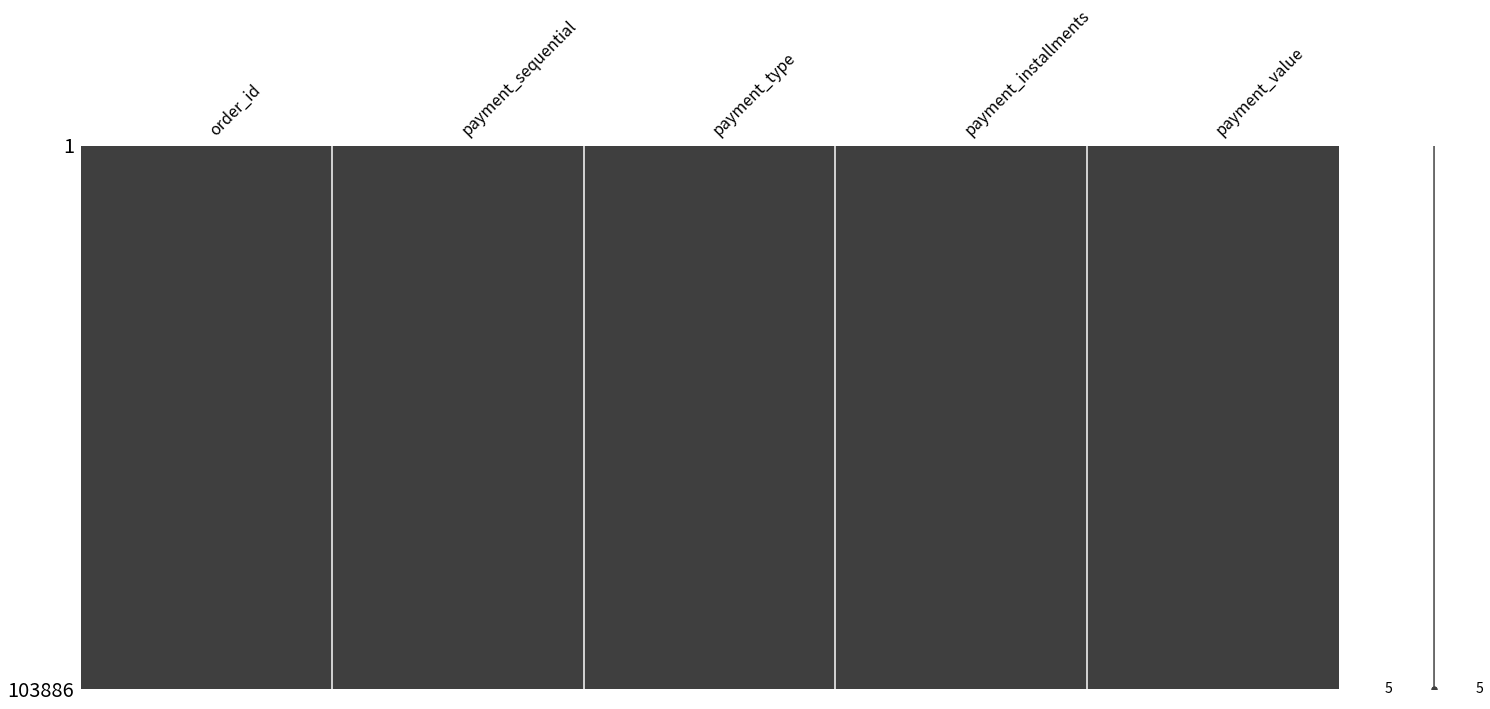

In [14]:
order_payments_data = pd.read_csv("olist_order_payments_dataset.csv")
missingValuesInfos(order_payments_data)

Variable :
- order_id : id de la commande
- payment_sequential : numéro de paiement pour une commande 
- payment_type : type de paiement
- payment_installements : 
- payment_value : montant

In [15]:
order_payments_data.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


Text(0, 0.5, 'Nombre de commandes')

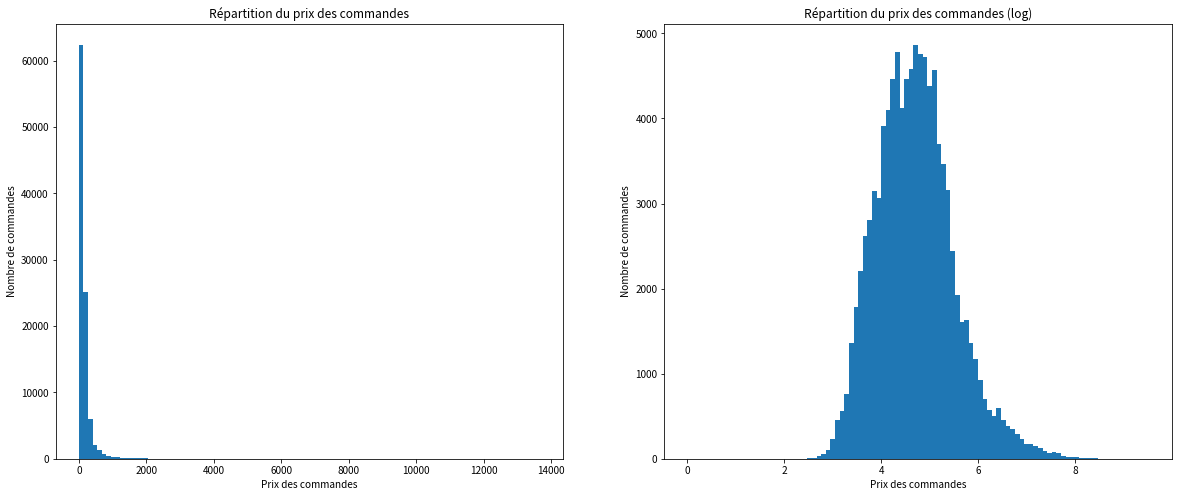

In [16]:
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
plt.hist(order_payments_data.loc[:,["order_id","payment_value"]].groupby("order_id").sum(), bins = 100)
plt.title("Répartition du prix des commandes")
plt.xlabel("Prix des commandes")
plt.ylabel("Nombre de commandes")
plt.subplot(1,2,2)
plt.hist(np.log(order_payments_data.loc[:,["order_id","payment_value"]].groupby("order_id").sum()+1), bins = 100)
plt.title("Répartition du prix des commandes (log)")
plt.xlabel("Prix des commandes")
plt.ylabel("Nombre de commandes")

## Orders

Il y a 4908 valeurs manquantes sur 795528 valeurs totales.
Le taux de remplissage est de : 99.38 %
Dimension du dataframe : (99441, 8)


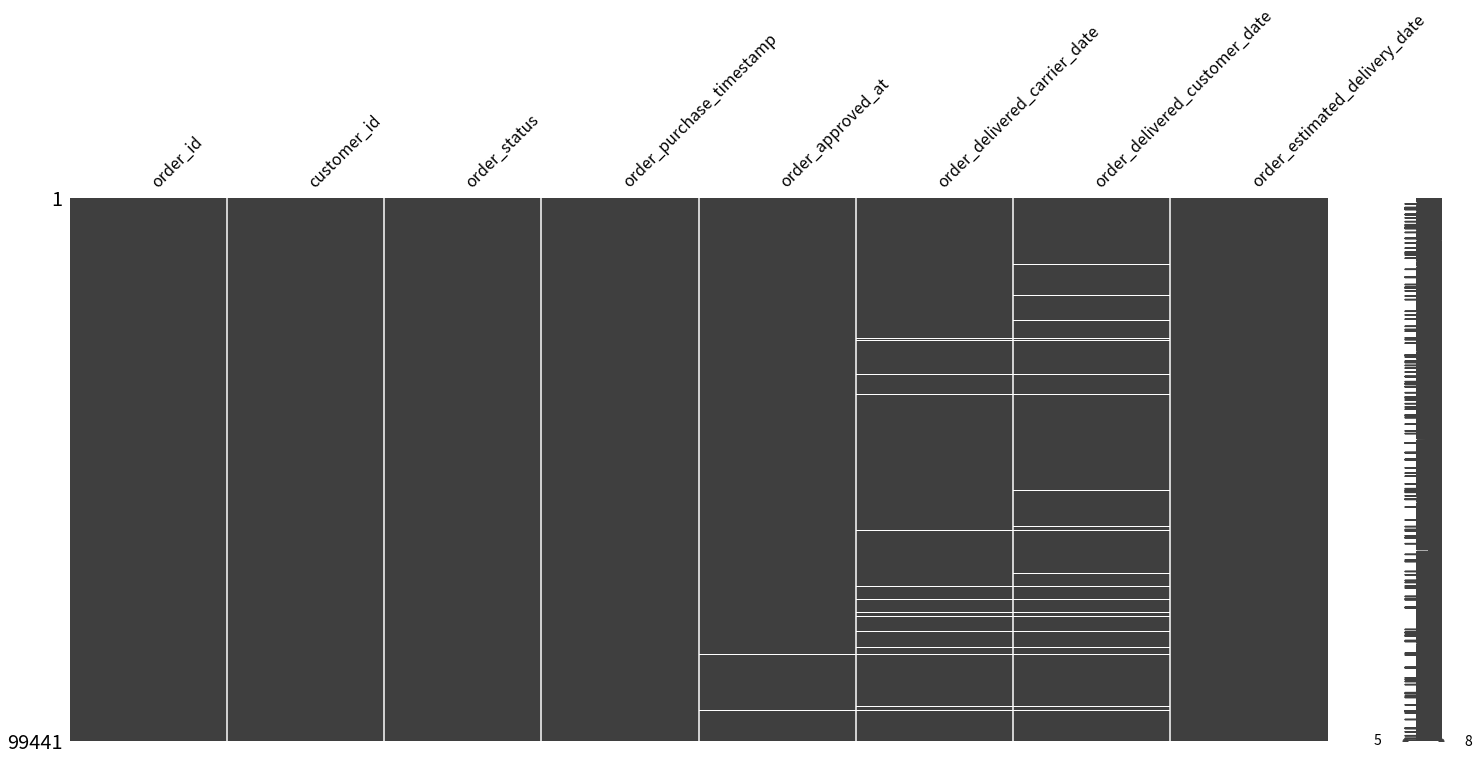

In [17]:
orders_data = pd.read_csv("olist_orders_dataset.csv")
missingValuesInfos(orders_data)

Variable :
- order_id : id de la commande
- customer_id : id de client
- order_status : statut de la commande
- order_purchase_timestamp : date d'achat
- order_approved_at : date d'acceptation de la commande
- order_delivered_carrier_date : date de remise de la commande au livreur
- order_delivered_customer_date : date de livraison
- order_estimated_delivery_date : date de livraison estimée

In [18]:
print(f"Première commande du site le {orders_data['order_purchase_timestamp'].min()}.")
print(f"Dernière commande du site le {orders_data['order_purchase_timestamp'].max()}.")
orders_data["order_status"].value_counts().sort_values(ascending = False)

Première commande du site le 2016-09-04 21:15:19.
Dernière commande du site le 2018-10-17 17:30:18.


delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

## reviews

Il y a 145903 valeurs manquantes sur 694568 valeurs totales.
Le taux de remplissage est de : 78.99 %
Dimension du dataframe : (99224, 7)


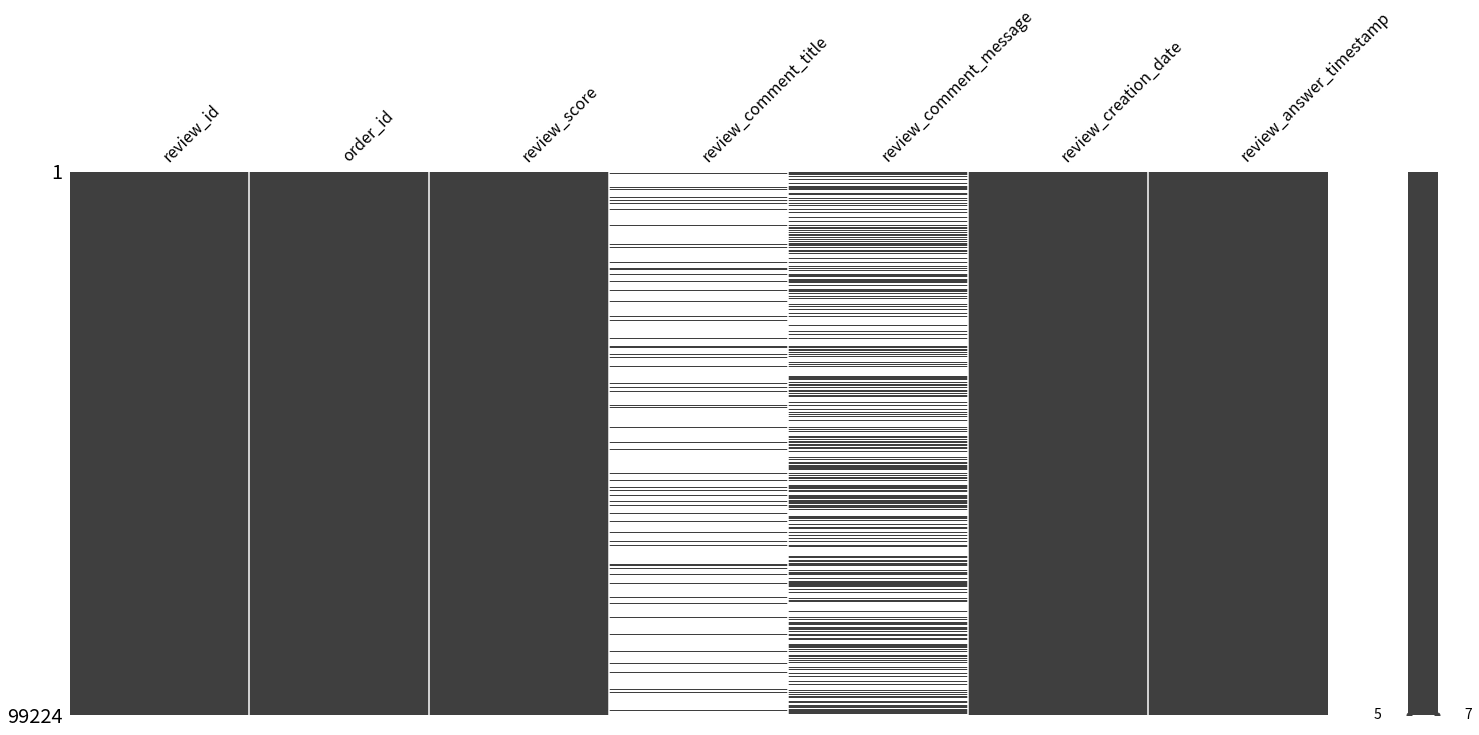

In [19]:
order_reviews_data = pd.read_csv("olist_order_reviews_dataset.csv")
missingValuesInfos(order_reviews_data)

Variable :
aucune clé primaire ici
- review_id : id du commentaire
- order_id : id de la commande (clé primaire apres nettoyage)
- review_score : score de la note (1-5)
- review_comment_title : titre du commentaire
- review_comment_message : commentaire
- review_creation_date : date du commentaire
- review_answer_timestamp : date de la réponse du vendeur

In [20]:
# on ne garde que la review la plus récente 
order_reviews_data.sort_values(by = ["order_id","review_creation_date"], inplace = True, ascending = False)
order_reviews_data.drop_duplicates(subset = "order_id", keep = 'first', inplace = True)
order_reviews_data.shape

(98673, 7)

Text(0.5, 1.0, 'Répartition des notes de score')

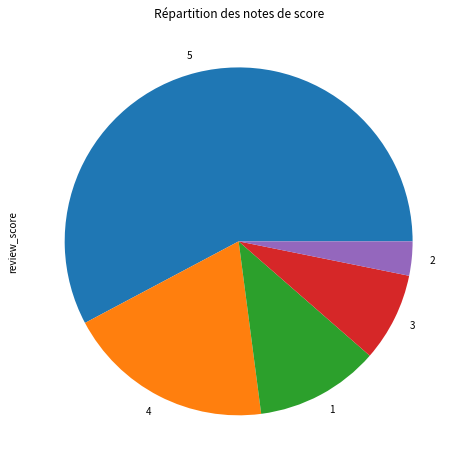

In [21]:
order_reviews_data["review_score"].value_counts().plot.pie(figsize = (8,8))
plt.title("Répartition des notes de score")

## Produits

Il y a 2448 valeurs manquantes sur 296559 valeurs totales.
Le taux de remplissage est de : 99.17 %
Dimension du dataframe : (32951, 9)


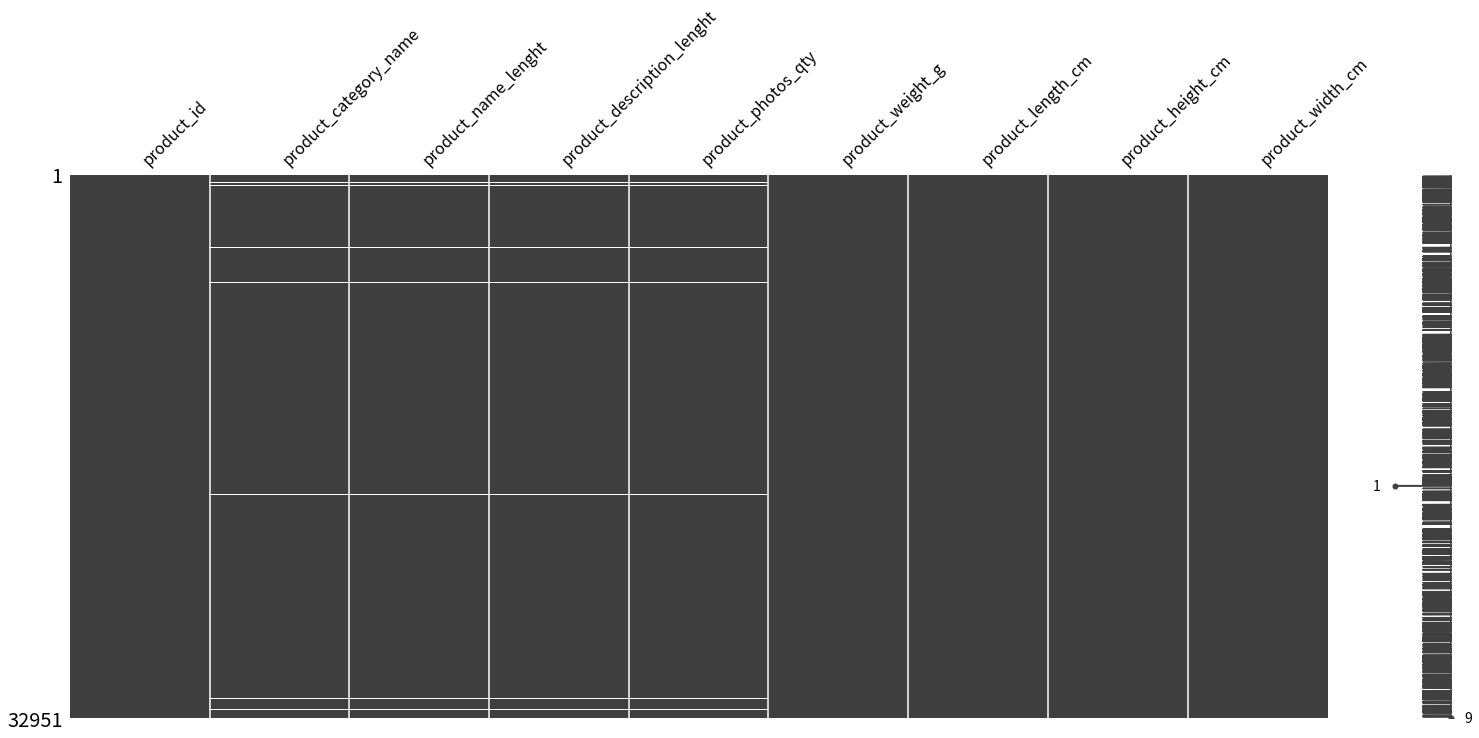

In [22]:
products_data = pd.read_csv("olist_products_dataset.csv")
missingValuesInfos(products_data)

Variable :
- product_id : id de l'article (clé primaire)
- product_category_name : nom de la catégorie de l'article
- product_name_lenght : nom de l'article
- product_description_lenght : longeur de la descriptionde l'article
- product_photos_qty : nombre de photos
- product_weight_g : poids de l'article
- product_length_cm : longueur de l'article
- product_height_cm : hauteur de l'article
- product_width_cm : largeur de l'article

In [23]:
products_data.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
mean,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


Text(0.5, 1.0, 'Répartion des articles en catégories')

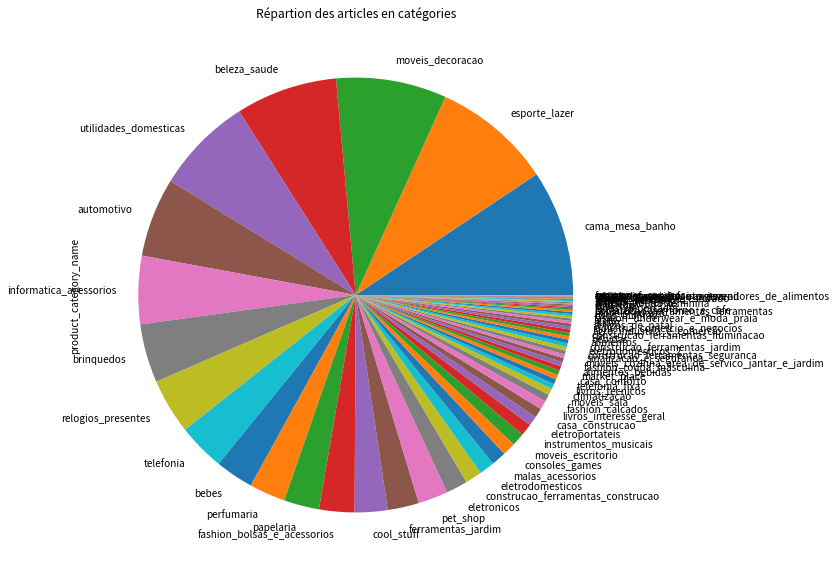

In [24]:
products_data["product_category_name"].value_counts().sort_values(ascending = False).plot.pie(figsize = (10,10))
plt.title("Répartion des articles en catégories")

## Vendeurs

Il y a 0 valeurs manquantes sur 12380 valeurs totales.
Le taux de remplissage est de : 100.0 %
Dimension du dataframe : (3095, 4)


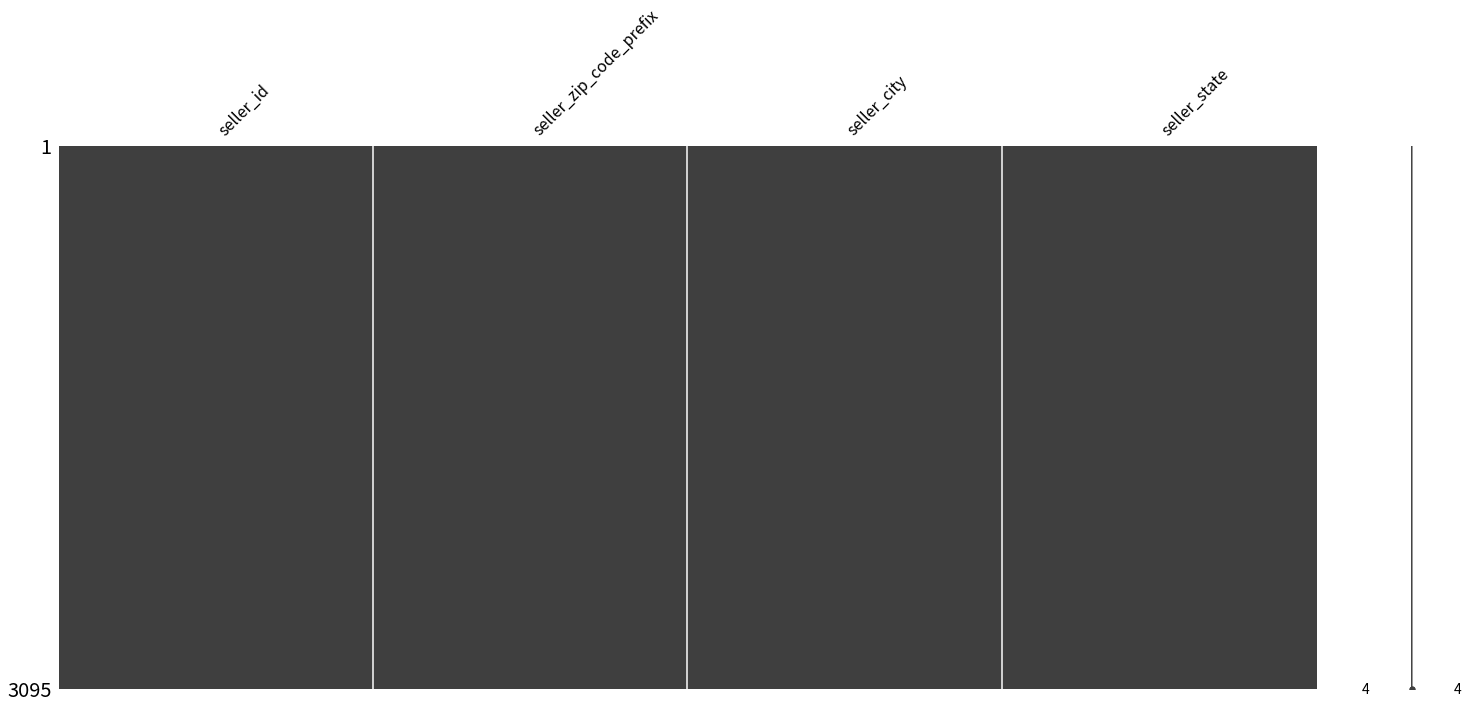

In [25]:
sellers_data = pd.read_csv("olist_sellers_dataset.csv")
missingValuesInfos(sellers_data)

Variable :
- seller_id : id du vendeur (clé primaire)
- seller_zip_code_prefix : code postal du vendeur
- seller_city : ville du vendeur
- seller_state : département du vendeur

In [26]:
sellers_data.loc[:,["seller_city","seller_state"]].describe()

,seller_city,seller_state
count,3095,3095
unique,611,23
top,sao paulo,SP
freq,694,1849


Text(0.5, 1.0, 'Répartition des vendeurs par département')

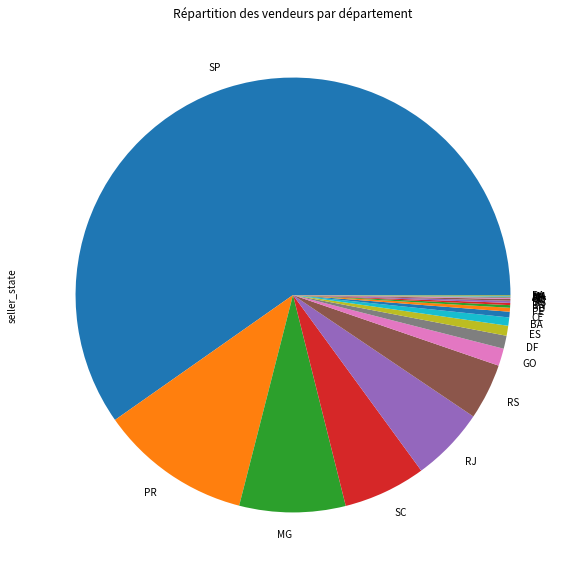

In [27]:
sellers_data["seller_state"].value_counts().plot.pie(figsize = (10,10))
plt.title("Répartition des vendeurs par département")

# JOINTURES

# Vue Ligne de commande

In [28]:
order_items_view = pd.merge(orders_data, order_items_data, on = "order_id")
order_items_view = pd.merge(order_items_view, products_data, on = "product_id")
order_items_view = pd.merge(order_items_view, sellers_data, on = "seller_id")
order_items_view = pd.merge(order_items_view, customers_data, on = "customer_id")

0    335
1    383
2    396
3    314
4    388
Name: order_purchase_timestamp, dtype: int64
Il y a 1621 valeurs manquantes sur 1802400 valeurs totales.
Le taux de remplissage est de : 99.91 %
Dimension du dataframe : (112650, 16)


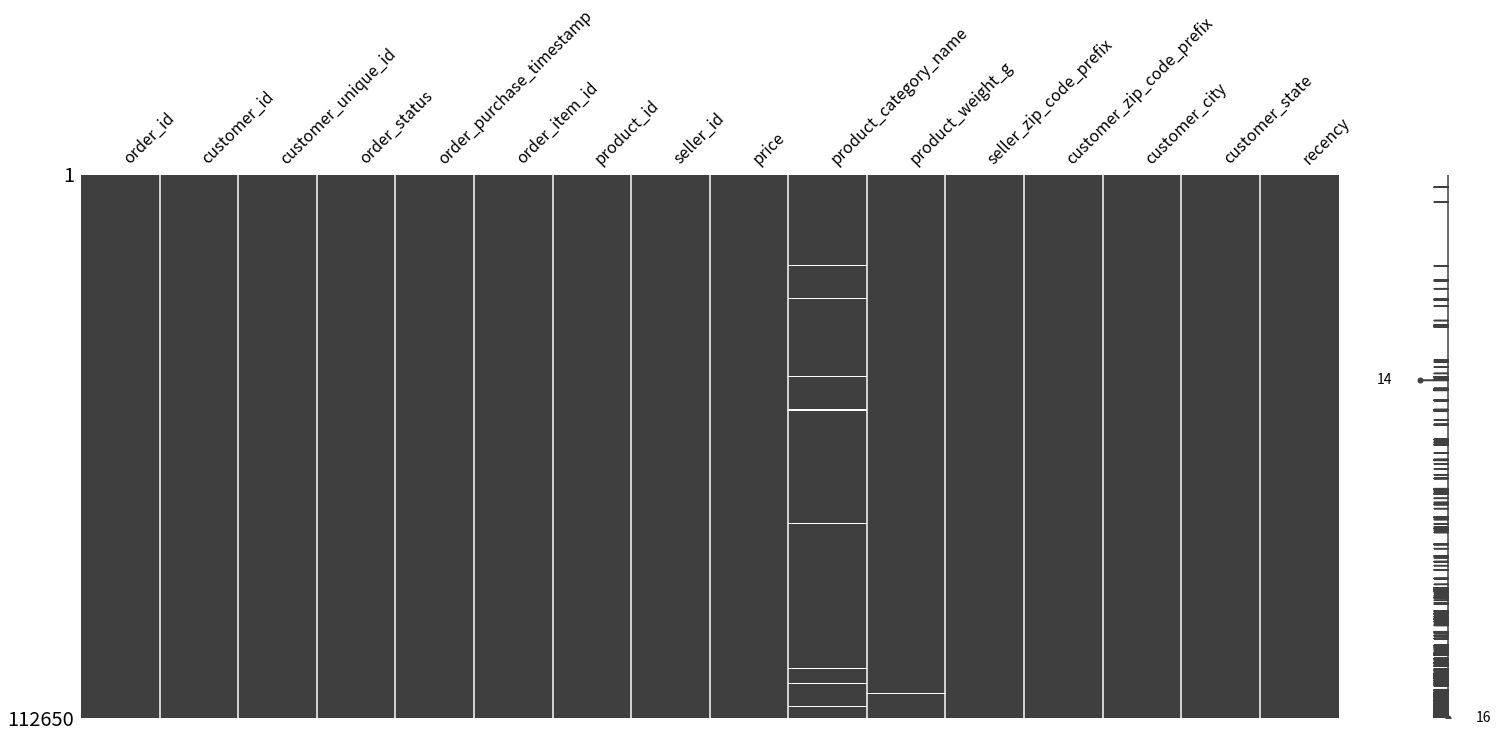

In [29]:
select_columns = ['order_id', 'customer_id','customer_unique_id','order_status','order_purchase_timestamp',
                  'order_item_id','product_id','seller_id','price',
                  'product_category_name','product_weight_g','seller_zip_code_prefix',
                  'customer_zip_code_prefix','customer_city','customer_state']
order_items_view = order_items_view.loc[:,select_columns]
order_items_view['order_purchase_timestamp'] = pd.to_datetime(order_items_view['order_purchase_timestamp'], format = "%Y-%m-%d %H:%M:%S")
today = order_items_view["order_purchase_timestamp"].max()
recency = (today - order_items_view["order_purchase_timestamp"])
recency = recency.dt.days
print(recency.head().astype(int))
order_items_view["recency"] = recency
missingValuesInfos(order_items_view)

Text(0.5, 0, 'Jours écoulés depuis la commande')

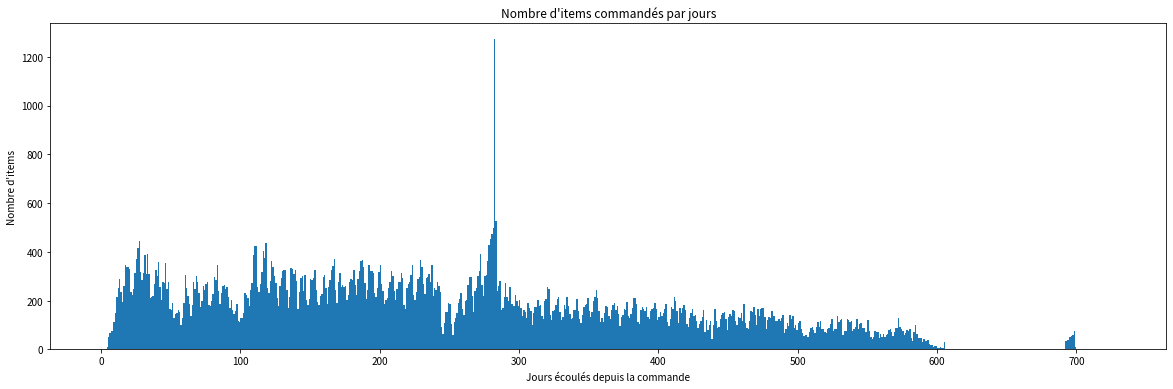

In [30]:
order_items_view["recency"].plot.hist(bins = order_items_view["recency"].max(), figsize = (20,6))
plt.title("Nombre d'items commandés par jours")
plt.ylabel("Nombre d'items")
plt.xlabel("Jours écoulés depuis la commande")

Text(0.5, 1.0, 'Répartition des articles commandés en catégories')

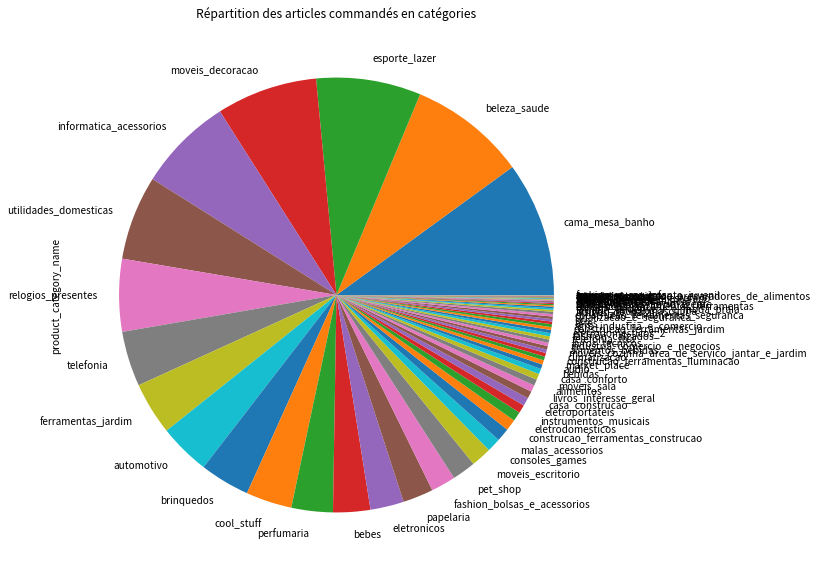

In [31]:
order_items_view["product_category_name"].value_counts().plot.pie(figsize = (10,10))
plt.title('Répartition des articles commandés en catégories')

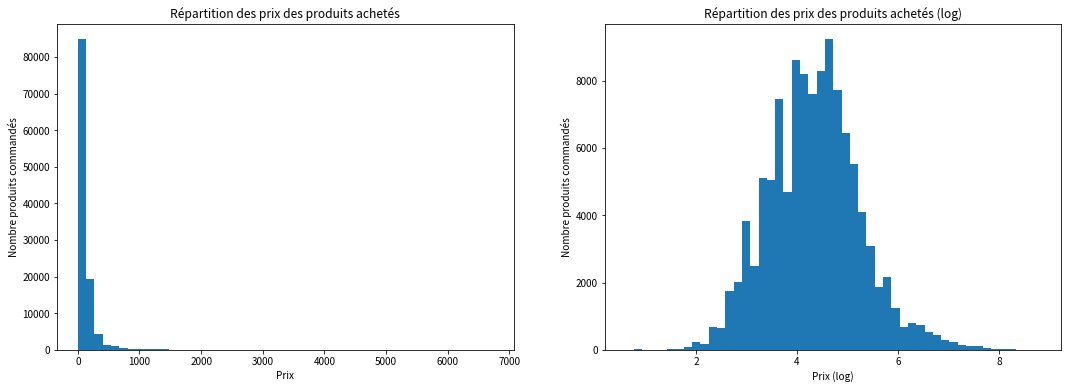

count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64


In [32]:
plt.figure(figsize = (18,6))
plt.subplot(1,2,1)
plt.hist(order_items_view["price"], bins = 50)
plt.title("Répartition des prix des produits achetés")
plt.xlabel("Prix")
plt.ylabel("Nombre produits commandés")
plt.subplot(1,2,2)
plt.hist(np.log(1+order_items_view["price"]), bins = 50)
plt.title("Répartition des prix des produits achetés (log)")
plt.xlabel("Prix (log)")
plt.ylabel("Nombre produits commandés")
plt.show()
print(order_items_view["price"].describe())

# Vue commandes

In [33]:
orders_view = order_items_view.groupby('order_id').agg({'customer_id' : 'first',
                                                        'customer_unique_id' : 'first',
                                                        'customer_zip_code_prefix' : 'first',
                                                        'customer_city' : 'first',
                                                        'order_item_id' : 'max',
                                                        'order_purchase_timestamp' : 'first',
                                                        'recency' : 'min',
                                                        'price' : 'sum',
                                                        'product_category_name' : pd.Series.mode,
                                                        'product_weight_g' : 'sum'})
orders_view.columns = ['customer_id','customer_unique_id','customer_zip_code_prefix','customer_city','number_of_items','purchase_date','recency','order_price','main_category','total_weight_g']
orders_view = pd.merge(orders_view, order_reviews_data, on = "order_id")

In [34]:
orders_view = orders_view.loc[:,['customer_id','customer_unique_id','customer_zip_code_prefix','customer_city',
                                 'number_of_items','purchase_date','recency','order_price','main_category','total_weight_g','review_score']]
orders_view.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,number_of_items,purchase_date,recency,order_price,main_category,total_weight_g,review_score
0,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,1,2017-09-13 08:59:02,355,58.90,cool_stuff,650.0,5
1,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,1,2017-04-26 10:53:06,494,239.90,pet_shop,30000.0,4
2,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,1,2018-01-14 14:33:31,231,199.00,moveis_decoracao,3050.0,5
3,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,1,2018-08-08 10:00:35,25,12.99,perfumaria,200.0,4
4,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,1,2017-02-04 13:57:51,575,199.90,ferramentas_jardim,3750.0,5


In [35]:
in_current_year = orders_view["recency"] < 366
orders_view['in_current_year'] = in_current_year

Text(0.5, 0, 'Jours écoulés depuis la commande')

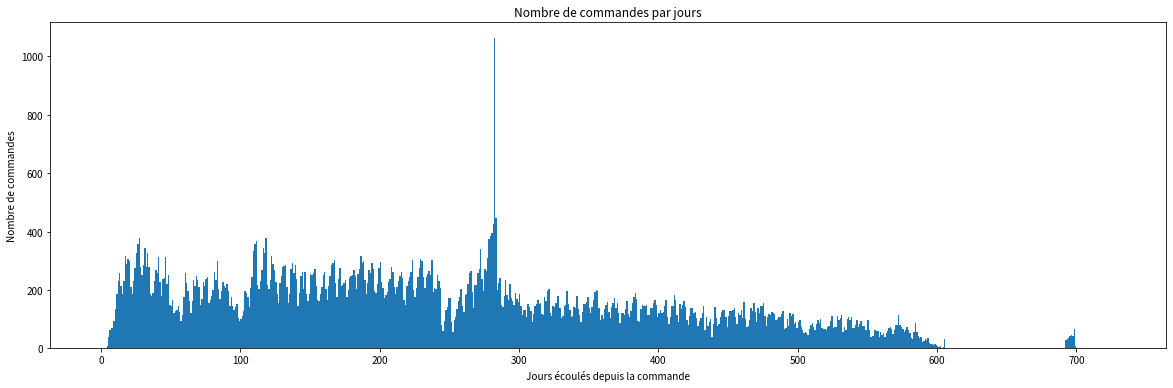

In [36]:
orders_view["recency"].plot.hist(bins = orders_view["recency"].max(), figsize = (20,6))
plt.title("Nombre de commandes par jours")
plt.ylabel("Nombre de commandes")
plt.xlabel("Jours écoulés depuis la commande")

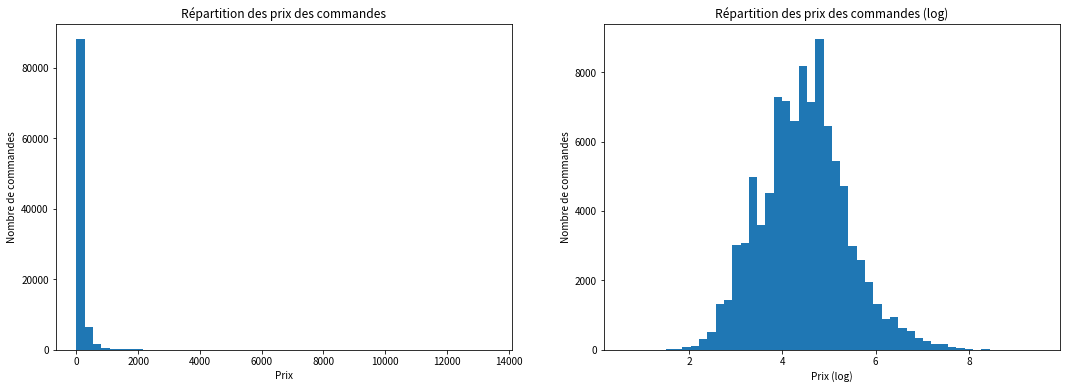

count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64


In [37]:
plt.figure(figsize = (18,6))
plt.subplot(1,2,1)
plt.hist(orders_view["order_price"], bins = 50)
plt.title("Répartition des prix des commandes")
plt.xlabel("Prix")
plt.ylabel("Nombre de commandes")
plt.subplot(1,2,2)
plt.hist(np.log(1+orders_view["order_price"]), bins = 50)
plt.title("Répartition des prix des commandes (log)")
plt.xlabel("Prix (log)")
plt.ylabel("Nombre de commandes")
plt.show()
print(order_items_view["price"].describe())

# Vue client

In [38]:
customers_view = orders_view.groupby('customer_unique_id').agg({'customer_id' : 'count',
                                                                'customer_city' : pd.Series.mode,
                                                                'customer_zip_code_prefix' : 'first',
                                                                'number_of_items' : ['mean','sum'],
                                                                'purchase_date' : ['min','max'],
                                                                'order_price' : ['mean','max','sum'],
                                                                'total_weight_g' : 'mean',
                                                                'review_score' : 'mean'})
customers_view.columns = ["number_of_orders","customer_city",'zip_code_prefix',"items_per_order","number_of_items","first_order_date",
                          "last_order_date","mean_order_price","max_order_price","total_money_spend","mean_weight_order",'satisfaction']
customers_view["satisfaction"] = customers_view["satisfaction"].round(1)
customers_view.head()

,number_of_orders,customer_city,zip_code_prefix,items_per_order,number_of_items,first_order_date,last_order_date,mean_order_price,max_order_price,total_money_spend,mean_weight_order,satisfaction
customer_unique_id,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,cajamar,7787,1.0,1,2018-05-10 10:56:27,2018-05-10 10:56:27,129.90,129.90,129.90,1500.0,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,osasco,6053,1.0,1,2018-05-07 11:11:27,2018-05-07 11:11:27,18.90,18.90,18.90,375.0,4.0
0000f46a3911fa3c0805444483337064,1,sao jose,88115,1.0,1,2017-03-10 21:05:03,2017-03-10 21:05:03,69.00,69.00,69.00,1500.0,3.0
0000f6ccb0745a6a4b88665a16c9f078,1,belem,66812,1.0,1,2017-10-12 20:29:41,2017-10-12 20:29:41,25.99,25.99,25.99,150.0,4.0
0004aac84e0df4da2b147fca70cf8255,1,sorocaba,18040,1.0,1,2017-11-14 19:45:42,2017-11-14 19:45:42,180.00,180.00,180.00,6050.0,5.0


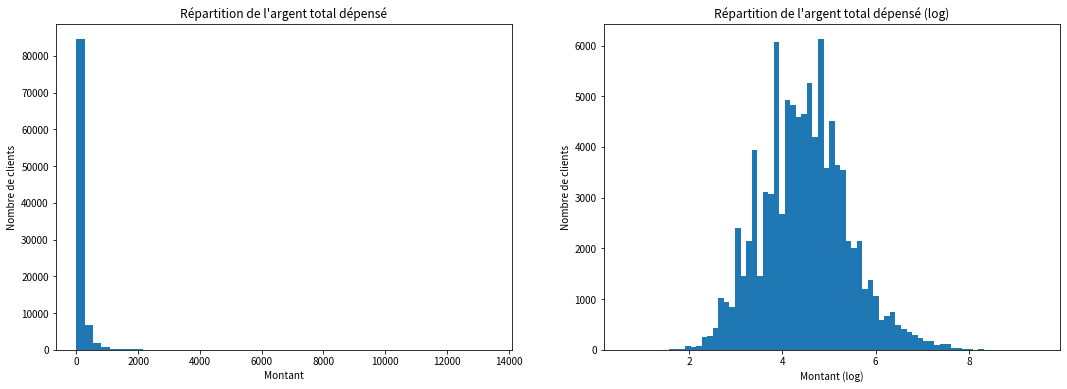

count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64


In [39]:
plt.figure(figsize = (18,6))
plt.subplot(1,2,1)
plt.hist(customers_view["total_money_spend"], bins = 50)
plt.title("Répartition de l'argent total dépensé")
plt.xlabel("Montant")
plt.ylabel("Nombre de clients")
plt.subplot(1,2,2)
plt.hist(np.log(1+customers_view["total_money_spend"]), bins = 75)
plt.title("Répartition de l'argent total dépensé (log)")
plt.xlabel("Montant (log)")
plt.ylabel("Nombre de clients")
plt.show()
print(order_items_view["price"].describe())

Text(0, 0.5, 'Nombre de clients')

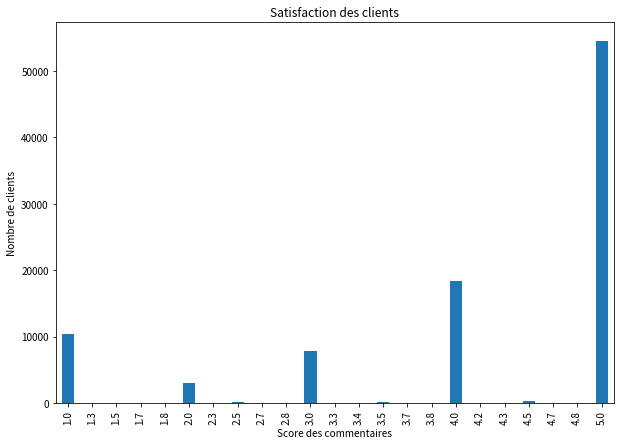

In [40]:
customers_view['satisfaction'].value_counts().sort_index().plot.bar(figsize = (10,7))
plt.title('Satisfaction des clients')
plt.xlabel('Score des commentaires')
plt.ylabel('Nombre de clients')

In [41]:
today = customers_view["last_order_date"].max()
customers_view['last_order_date'] = pd.to_datetime(customers_view['last_order_date'], format = "%Y-%m-%d %H:%M:%S")
recency = (today - customers_view["last_order_date"])
recency = recency.dt.days
model_data = pd.DataFrame({'recency' : recency,
                           'frequency' : customers_view["number_of_orders"],
                           'monetary' : customers_view["total_money_spend"].round(0).astype(int),
                           'satisfaction' : customers_view["satisfaction"]})
model_data.sort_index(inplace = True)
model_data.to_csv("modelData.csv")
print(model_data.shape)
model_data.head()

(94721, 4)


,recency,frequency,monetary,satisfaction
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,130,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,19,4.0
0000f46a3911fa3c0805444483337064,541,1,69,3.0
0000f6ccb0745a6a4b88665a16c9f078,325,1,26,4.0
0004aac84e0df4da2b147fca70cf8255,292,1,180,5.0


In [42]:
orders_view.to_csv('orders_view.csv')